In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc
from datetime import datetime as dt, timedelta
from sqlalchemy import select 
from sqlalchemy import table, column

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:

columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


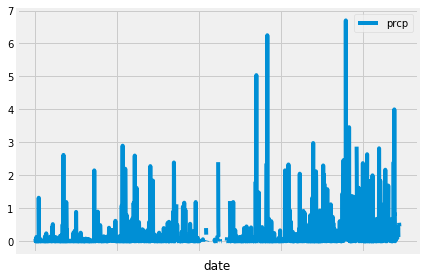

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


min_dt = engine.execute('SELECT min(date) Min_dt  FROM measurement LIMIT 10').fetchall()
max_dt = engine.execute('SELECT max(date) Max_dt  FROM measurement LIMIT 10').fetchall()
max_dt = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

d = dt.strptime(max_dt,"%Y-%m-%d")






# Calculate the date 1 year ago from the last data point in the database
year_ago = d - timedelta(days=365)
#year_ago

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date  >= year_ago).all()
#data

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(data, columns=['date', 'prcp'])
#df
# Sort the dataframe by date
new_df = df.sort_values('date',ascending = True)
#new_df
# Use Pandas Plotting with Matplotlib to plot the data
df.set_index('date', inplace=True)
df.plot()
plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [14]:
sample_data = engine.execute('SELECT *  FROM station LIMIT 10').fetchall()
sample_data

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [15]:
# Design a query to show how many stations are available in this dataset?
avail_station = engine.execute('SELECT count(id)  FROM station LIMIT 10').fetchall()
avail_station

[(9,)]

In [36]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

sel = [Measurement.station, func.count(Measurement.tobs)]
active_stations_data = session.query(*sel).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()
active_stations_data


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [51]:
# highest number of temp observations
active_stations_data[0][0]

'USC00519281'

In [39]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

sample_data = engine.execute('SELECT min(tobs) MIN_TEMP,max(tobs) MAX_TEMP,avg(tobs) AVG_TEMP  FROM Measurement where station = "USC00519281"').fetchall()


sample_data = pd.DataFrame(sample_data, columns=['MIN_TEMP', 'MAX_TEMP', 'AVG_TEMP'])
sample_data 


,MIN_TEMP,MAX_TEMP,AVG_TEMP
0,54.0,85.0,71.663781


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


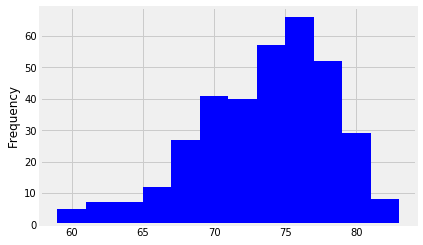

In [55]:
sel = [Measurement.tobs]
temp_obs_12_mth = session.query(Measurement.tobs).\
    filter(Measurement.date  >= year_ago).\
    filter(Measurement.station == active_stations_data[0][0]).all()

temp_lst = []

for row in temp_obs_12_mth :
    temp_lst.append(row[0])

plt.hist(temp_lst, bins=12, label='tobs', color = 'blue')
plt.ylabel("Frequency")
plt.savefig("Images/station-histogram.png")
plt.show()

![precipitation](Images/station-histogram.png)

In [57]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):

    Start_Date = dt.strptime(start_date, "%Y-%m-%d")
    Start_Date = Start_Date.replace(Start_Date.year - 1)
    End_Date = dt.strptime(end_date, "%Y-%m-%d")
    End_Date = End_Date.replace(End_Date.year - 1)
    
    delta = End_Date - Start_Date
    date_range = []
    for i in range(delta.days + 1):
        date_range.append(Start_Date + timedelta(days=i))
       
    str_date_range = []
    for date in date_range:
        new_date = date.strftime("%Y-%m-%d")
        str_date_range.append(new_date)
       
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-12'))

[(61.0, 69.17142857142858, 75.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
